# Pipeline for Performing Differential Gene Expression Analysis

> **This Jupyter Notebook (JN) was built to teach students how to perform differential gene expression (DGE) analysis with DESeq2 using the [GeneLab standard pipeline, version F](https://github.com/nasa/GeneLab_Data_Processing/blob/master/RNAseq/Pipeline_GL-DPPD-7101_Versions/GL-DPPD-7101-F.md). Below are step-by-step instructions for determining differentially expressed genes in a select pairwise group comparison in any RNAseq GeneLab Data Set (GLDS) hosted on the [Open Science Data Repository (OSDR)](https://osdr.nasa.gov/bio/repo), starting with RSEM raw counts data.** 
>   - Note: Since this JN requires RSEM raw counts data as input, only GLDS datasets that have raw counts data on the OSDR can be analyzed.

---

### DGE Workflow

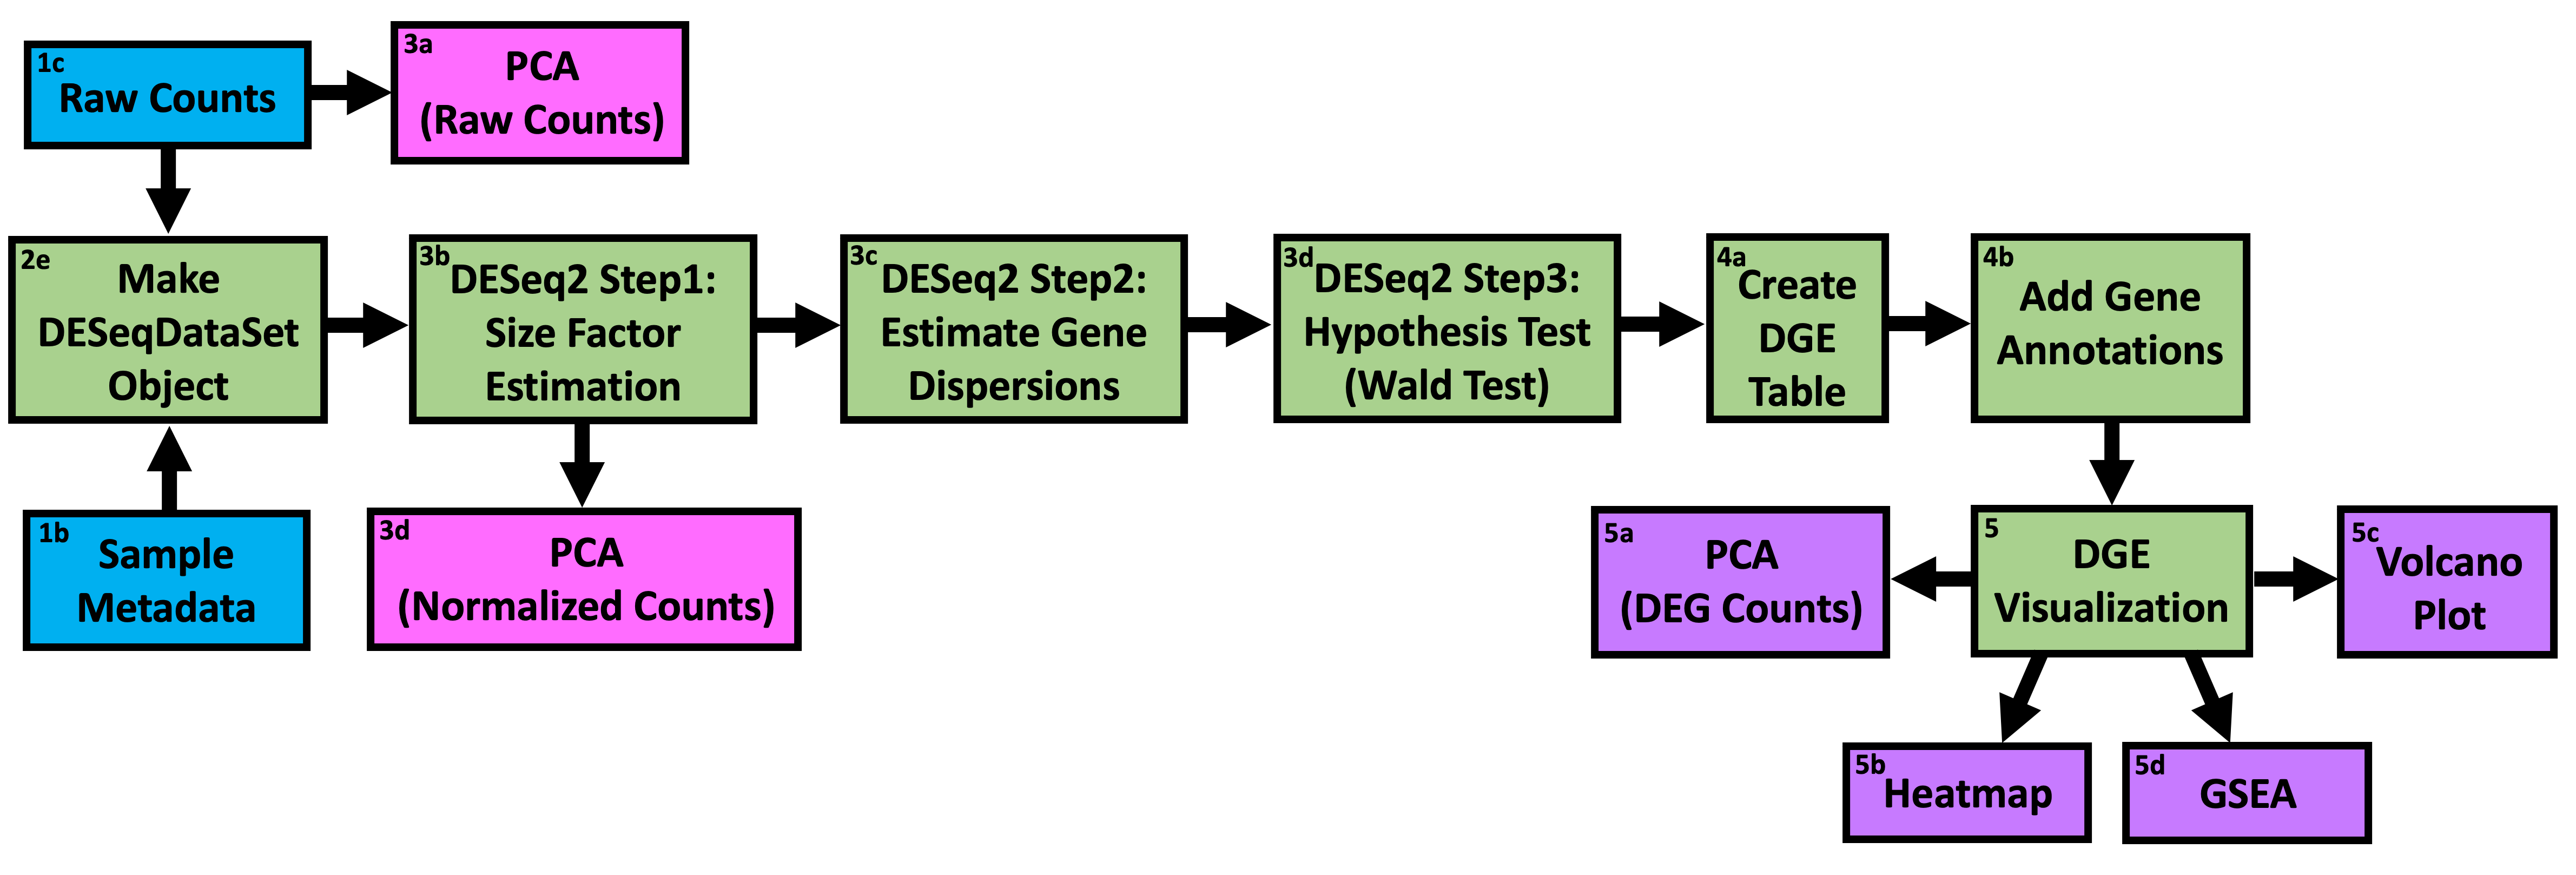

# Table of Contents 


* [0. Create Directory Structure for Processed Data](#dirstructure)
* [1. Download the Metadata and Data](#data)
    * [1a. Set up Directory Path Variables](#dirs)
    * [1b. Download and Format the Metadata](#download)
    * [1c. Download the Raw Counts Files](#downloadcounts)
* [2. Import and Format the Metadata and Data in R](#dataR)
    * [2a. Load R libraries](#loadR)
    * [2b. Set up Directory Path Variables in R](#dirsR)
    * [2c. Import and Format Sample Metadata in R](#metadataR)
    * [2d. Import and Format Raw Counts Data in R](#rawdataR)
    * [2e. Make DESeqDataSet Object](#deseqdataset)
* [3. DESeq2 Data Normalization](#deseq)
    * [3a. PCA of Raw, Unnormalized Count Data](#unnormalized)
    * [3b. DESeq2 Step 1: Size Factor Estimation](#sizefactor)
    * [3c. DESeq2 Step 2: Estimate Gene Dispersions](#dispersions)
    * [3d. DESeq2 Step 3: Hypothesis Testing with Wald Test](#wald)
* [4. DGE Analysis](#dge)
    * [4a. Perform Data Calculations and Create DGE Output Table](#calculations)
    * [4b. Add Gene Annotations](#annotations)
* [5. DGE Data Visualization](#vis)
    * [5a. PCA](#pca)
    * [5b. Heatmap](#heatmap)
    * [5c. Volcano Plot](#volcano)
    * [5d. Gene Set Enrichment Analysis (GSEA)](#gsea)




---

**Note: This JN uses Bash and R kernels. Pay attention to the required kernel indicated under each section title.**

---

<a class="anchor" id="dirstructure"></a>
# 0. Create Directory Structure for Processed Data
> **Required kernel:** Bash

In the code block below, define the OSD/GLDS dataset you want to process by replacing `OSD-###` and `GLDS-###` with the appropriate OSD and GLDS number for your select dataset indicated in the [OSDR](https://osdr.nasa.gov/bio/repo):

In [ ]:
OSD=OSD-104
GLDS=GLDS-104

Before running any analyses, let's create a directory structure to store the data. Throughout this JN, you will download and generate several files so it is important to keep theses files organized.

Let's start by creating a top level directory for your selected OSD/GLDS dataset number:

In [ ]:
mkdir ${OSD}_${GLDS}

The next series of commands will be used to create sub-directories within the OSD-###_GLDS-### top-level directory you just created (with the command above) to store the data from each step in the RNAseq processing pipeline, starting with RSEM counts files.

Create sub-directory for metadata:

In [ ]:
mkdir ./${OSD}_${GLDS}/Metadata

Create sub-directory for individual, raw count data:

In [ ]:
mkdir ./${OSD}_${GLDS}/03-RSEM_Counts

Create sub-directories for combined raw and normalized counts tables and PCA data/plots:

In [ ]:
mkdir ./${OSD}_${GLDS}/04-DESeq2_NormCounts
mkdir ./${OSD}_${GLDS}/04-DESeq2_NormCounts/PCA

Create sub-directory for differential expression analysis data:

In [ ]:
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/PCA
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/Heatmaps
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/VolcanoPlots
mkdir ./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/GSEA

<br>

---

<a class="anchor" id="data"></a>
# 1. Download the Metadata and Data
> **Required kernel:** Bash

<a class="anchor" id="dirs"></a>
## 1a. Set up Directory Path Variables

Let's start by creating variables (in Bash) to define the locations for our input metadata and count data and to indicate the location where the output data will be printed.

In [ ]:
metadata_dir=./${OSD}_${GLDS}/Metadata
counts_dir=./${OSD}_${GLDS}/03-RSEM_Counts
norm_output=./${OSD}_${GLDS}/04-DESeq2_NormCounts
pca_dir=./${OSD}_${GLDS}/04-DESeq2_NormCounts/PCA
DGE_output=./${OSD}_${GLDS}/05-DESeq2_DGE
DGE_pca=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/PCA
DGE_heatmaps=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/Heatmaps
DGE_volcano=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/VolcanoPlots
DGE_gsea=./${OSD}_${GLDS}/05-DESeq2_DGE/DGE_plots/GSEA

<br>

<a class="anchor" id="download"></a>
## 1b. Download and Format the Metadata

To process the data in your select dataset, you'll need to know some information about the samples and experimental design, this information is known as metadata. In the [OSDR](https://osdr.nasa.gov/bio/repo), all the metadata for each dataset is held in the downloadable \*ISA.zip file. 

The command in the code block below will execute the `download_files_urls.py` python script, which allows you to download files from any dataset in the [OSDR](https://osdr.nasa.gov/bio/repo). The `download_files_urls.py` python script requires the following 3 inputs:
1) The OSD number for your dataset, held in the `OSD` variable you created in [Step 0](#dirstructure)
2) The extension of the file(s) you want to download from your dataset
3) The location where you want the select files downloaded 

Run the code block below to download the \*ISA.zip file for your dataset into the metadata sub-directory you created in [Step 0](#dirstructure):

In [ ]:
python download_file_urls.py $OSD ISA.zip $metadata_dir/


Check that the \*ISA.zip file has been downloaded to your `Metadata` subdirectory:

In [ ]:
ls $metadata_dir/

The \*ISA.zip file download above contains several files holding all the metadata associated with your select dataset but you only need a subset of those metadata to perform DGE analysis. Therefore, in the next code block you will use [dp_tools](https://github.com/J-81/dp_tools) to parse the metadata in the \*ISA.zip file and create a runsheet containing the metadata needed to perform DGE analysis then move your output runsheet into the metadata sub-directory:

In [ ]:
dpt-isa-to-runsheet --accession $OSD \
    --config-type bulkRNASeq \
    --config-version Latest \
    --isa-archive $metadata_dir/*ISA.zip 

mv *runsheet.csv $metadata_dir/

Check that the \*runsheet.csv file has been created and is in your `Metadata` subdirectory:

In [ ]:
ls $metadata_dir/

Use the following code block to view the \*runsheet.csv file:

In [ ]:
column -s, -t $metadata_dir/*runsheet.csv 

**Take a look at the \*runsheet.csv content and answer the following questions:**

1. What type(s) of information have been added in the runsheet?

2. How many samples are in your dataset?
   > Hint: Add a code block and use the `cat` and `wc -l` commands to count the number of rows in the runsheet (don't forget to subtract one to account for the column names).

3. Which column(s) contain information needed to perform differential gene expression analysis (DGE)? Why?

<br>

<a class="anchor" id="downloadcounts"></a>
## 1c. Download the Raw Counts Files

To perform DGE analysis, in addition to the metadata, you will also need to download the raw gene counts from each sample in your dataset from the [OSDR](https://osdr.nasa.gov/bio/repo). The `download_files_urls.py` python script that you used in [Steb 1b](#download) to download the \*ISA.zip file (containing the metadata) can also be used to download the \*.genes.results file from each sample in your dataset by running the code block below:
> Recall: The \*.genes.results file is the output file generated by [RSEM](https://github.com/deweylab/RSEM) that contains the expression estimates per gene.

In [ ]:
python download_file_urls.py $OSD genes.results $counts_dir

Check that the \*genes.results files have been downloaded to your `03-RSEM_Counts` subdirectory:

In [ ]:
ls $counts_dir

Count the \*genes.results files to make sure the number of files match the number of samples in your dataset:

In [ ]:
ls -1 $counts_dir/*genes.results | wc -l

Remove the "GLDS-###\_rna_seq_" prefix from all \*genes.results files:
> This is done so that the file names match the sample names in the \*runsheet.csv file created in [Step 1b](#download) above, which is required for [Step 2d](#rawdataR) below.

In [ ]:
find $counts_dir/ -name "*genes.results" | sed -e "p;s/${GLDS}_rna_seq_//" | xargs -n2 mv

Check that the "GLDS-###\_rna_seq_" prefix has been removed from all \*genes.results files in your `03-RSEM_Counts` subdirectory:

In [ ]:
ls $counts_dir

<br>

---

<a class="anchor" id="dataR"></a>
# 2. Import and Format the Metadata and Data in R
> **Required kernel:** R

Now that you have all the input files you need, you're ready to run differential gene expression (DGE) analysis. 

You will be performing your DGE analysis in the R programming language using several R packages, which have all been installed for you. Prior to beginning the analysis, you'll first have to load the R packages you will be using by importing the library directories where they are stored. 

<a class="anchor" id="loadR"></a>
## 2a. Load R libraries

Load the R library that will allow you to import the RSEM raw counts data: 

In [ ]:
library(tximport)

Import R libraries that will allow us to run DGE analysis with DESeq2:

In [ ]:
library(DESeq2)
library(tidyverse)
library(stringr)

In [ ]:
library(stringr)

Import R libraries that will allow us to perform data visualization:

In [ ]:
library(ggplot2)
library(ggfortify)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(tidyHeatmap)
library(clusterProfiler)
library(goseq)
library(fgsea)
library(enrichplot)
library(ggplot2)
library(ggnewscale)

<br>

<a class="anchor" id="dirsR"></a>
## 2b. Set up Directory Path Variables in R

Create variables (in R) to define the location of your input metadata and raw counts files and to indicate where the output data you generate will be printed:
> Note: In the code block below, replace the `OSD-###` and `GLDS-###` with the appropriate OSD and GLDS number for your select dataset indicated in the [OSDR](https://osdr.nasa.gov/bio/repo):

In [ ]:
OSD="OSD-104"
GLDS="GLDS-104"

runsheet_path=paste("./", OSD, "_", GLDS, "/Metadata/", OSD, "_bulkRNASeq_v1_runsheet.csv", sep="")
counts_dir=paste("./", OSD, "_", GLDS, "/03-RSEM_Counts", sep="") 
norm_output=paste("./", OSD, "_", GLDS, "/04-DESeq2_NormCounts", sep="")
pca_dir=paste("./", OSD, "_", GLDS, "/04-DESeq2_NormCounts/PCA", sep="")
DGE_output=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE", sep="")
DGE_pca=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/PCA", sep="")
DGE_heatmaps=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/Heatmaps", sep="")
DGE_volcano=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/VolcanoPlots", sep="")
DGE_gsea=paste("./", OSD, "_", GLDS, "/05-DESeq2_DGE/DGE_plots/GSEA", sep="")

Check the `runsheet_path` variable created above and make sure the \*runsheet.csv file name matches the name of the \*runsheet.csv file created for your dataset (output of the second `ls $metadata_dir/` command in [Step 1b](#download)).
> If they don't match, modify the definition of `runsheet_path` accordingly in the code block above then re-run the code block and check again.

In [ ]:
runsheet_path

<br>

<a class="anchor" id="metadataR"></a>
## 2c. Import and Format Sample Metadata in R

Before you perform any analysis, you'll need to import the two types of input data downloaded in [Step 1](#data) above, the metadata and raw counts data. First, you will import the \*runsheet.csv file that you created in [Step 1b](#download) and use the info to define the sample groups for subsequent DGE analysis. 

#### Import the \*runsheet.csv file and create a dataframe containing each sample and their respective factors: 
> The dataframe will be store it as the variable `study`

In [ ]:
##### Create function to pull in all factors for each sample in the study from the runsheet #####

compare_csv_from_runsheet <- function(runsheet_path) {
    df_rs = read.csv(runsheet_path)
    # get only Factor Value columns
    factors = as.data.frame(df_rs[,grep("Factor.Value", colnames(df_rs), ignore.case=TRUE)])
    colnames(factors) = paste("factor",1:dim(factors)[2], sep= "_")
    result = data.frame(sample_id = df_rs[,c("Sample.Name")], factors)
    return(result)
}


### Run the function created above to import the metadata needed for DGE from your *runsheet.csv file ###

compare_csv <- compare_csv_from_runsheet(runsheet_path)


### Create a data frame containing all samples from your dataset and their respective factors ###

study <- as.data.frame(compare_csv[,2:dim(compare_csv)[2]])
colnames(study) <- colnames(compare_csv)[2:dim(compare_csv)[2]]
rownames(study) <- compare_csv[,1]

Take a look at the `study` data frame: 
> Note that the first column contains sample names and each subsequent column contains a treatment factor for that sample.

In [ ]:
study

<br>

#### Format factor metadata tables:
The next code block will use the information in the `study` data frame created above to generate a `group` variable that defines treatment groups based on the factors indicated for each sample. The `group` variable is then formatted so that it is compatible with R models:

In [ ]:
##### Format groups and indicate the group that each sample belongs to #####

if (dim(study)[2] >= 2){
  # Concatenate each factor to create one condition per sample
  group<-apply(study,1,paste,collapse = " & ") 
} else{
  group<-study[,1]
}


# Generate human readable group names
group_names <- paste0("(",group,")",sep = "") 


# Format group naming so that it is compatible with R models
# The term "BLOCKER_" is temporarily added as a prefix to each sample name,
  # this maintains the default behaviour of make.names, while ensuring that a 'X' is never 
  # prepended to group names beginning with a number
group <- sub("^BLOCKER_", "",  make.names(paste0("BLOCKER_", group))) 
names(group) <- group_names
rm(group_names)

Take a look at the information stored in the `group` variable: 
> Note that a group name is created for each sample by combining all the factors indicated for each respective sample in the \*runsheet.csv file.

In [ ]:
group

<br>

#### Define all the group comparisons to be used for DGE:
Unique sample groups are are used to create a `contrasts` data frame that defines the pairwise comparisons for all groups to be used for subsequent DGE analysis with [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html).


In [ ]:
# Generate matrix of pairwise group combinations for comparison
contrast.names <- combn(levels(factor(names(group))),2) 

# Limited make.names call for each group (also removes leading parentheses)
contrasts <- apply(contrast.names, MARGIN=2, function(col) sub("^BLOCKER_", "",  make.names(paste0("BLOCKER_", stringr::str_sub(col, 2, -2))))) 

# Format contrast combinations for output table files names
contrast.names <- c(paste(contrast.names[1,],contrast.names[2,],sep = "v"),paste(contrast.names[2,],contrast.names[1,],sep = "v")) 

# Add contrast combinations in the opposit direction
contrasts <- cbind(contrasts,contrasts[c(2,1),])

# Format column names
colnames(contrasts) <- contrast.names
rm(contrast.names) 

View the `contrasts` data frame containing the group comparisons that you made above:

In [ ]:
contrasts

**Use the contrasts table above to answer the following questions:**

1. How many comparisons are shown? What are they?
2. For the comparisons indicated above, if geneA is up-regulated in the samples in group 1 (compared with group 2), will the log fold change of geneA's expression be positive or negative in the group 1 vs. group 2 comparison? What about in the group 2 vs. group 1 comparison?

<br>

<a class="anchor" id="rawdataR"></a>
## 2d. Import and Format Raw Counts Data in R

Next, you will import the RSEM raw gene counts data using the \*genes.results files downloaded in [Step 1c](#downloadcounts) for each sample in your dataset.

#### Import RSEM raw gene counts for each sample:

First, we will specify the location of the \*genes.results files downloaded in [Step 1c](#downloadcounts) then order those files to be consistent with their respective sample order in the `study` data frame created in [Step 2c](#metadataR) above: 

In [ ]:
## List RSEM raw gene count files ##
files <- list.files(file.path(counts_dir),pattern = ".genes.results", full.names = TRUE)

## Reorder the *genes.results files to match the ordering of the samples in the study metadata ##
files <- files[sapply(rownames(study), function(x)grep(paste0(counts_dir, '/', x, ".genes.results$"), files, value=FALSE))]

names(files) <- rownames(study)

Take a look at the `files` variable, which contains the list of all \*gene.results files for your dataset: 

In [ ]:
files

Use [tximport](https://github.com/mikelove/tximport) to import the RSEM raw gene counts data from the \*gene.results files for each sample listed in `files` and store the data in the `txi.rsem` object:

In [ ]:
txi.rsem <- tximport(files, type = "rsem", txIn = FALSE, txOut = FALSE)

## Add 1 to genes with lengths of zero - needed to make DESeqDataSet object ##
txi.rsem$length[txi.rsem$length == 0] <- 1

#### Create a data frame mapping sample names to their respective groups

Use the group names held in the `group` variable created in [Step 2c](#metadataR) above to map each sample to its respective treatment group:
> Store the output data frame in the `sampleTable` variable

In [ ]:
sampleTable <- data.frame(condition=factor(group))
rownames(sampleTable) <- colnames(txi.rsem$counts)

View the `sampleTable` data frame, containing the sample group information, that you made above:

In [ ]:
sampleTable

**Use the sample table above to answer the following questions:**

1. What information is contained in the table?
2. How will this information be used to create a _DESeqDataSet_ object?

<br>

<a class="anchor" id="deseqdataset"></a>
## 2e. Make DESeqDataSet Object

We now need to format the sample group metadata and RSEM raw counts data so that DESeq2 can use it to perform DGE analysis. The DESeq2 algorithm requires an input called a _DESeqDataSet_ object, which is a special data format that holds gene expression data and sample group assignments. We will use the `DESeqDataSetFromTximport()` function provided by DESeq2 to convert your `txi.rsem` object, containing RSEM raw counts data, and the `sampleTable` data frame, containing sample group assignments, into a _DESeqDataSet_ object.

The `DESeqDataSetFromTximport()` function takes in:

> 1) the output of the tximport function, defined here as the `txi.rsem` variable,
> 2) a metadata table describing which group each sample belongs to, defined here as the `sampleTable` variable, and 
> 3) the condition in the metadata table for DESeq2 to use to group the samples for comparison. Here we only have one condition column in our `sampleTable`, titled "condition", in which samples are grouped based on their factor combination. 

The resulting _DESeqDataSet_ object, which we define as the variable `dds` in the command below, holds the counts data and the group assignments for each sample in an associated "design formula". As we continue analysis with DESeq2, our differential expression results will be added to the _DESeqDataSeq_ object in different slots.

In [ ]:
dds <- DESeqDataSetFromTximport(txi.rsem, sampleTable, ~condition)

We can view the summary of our new _DESeqDataSet_ object by running the command below.

In [ ]:
summary(dds)

**Based on the `summary(dds)` output, answer the following question:**

1. How many genes are stored in the _DESeqDataSet_ object?


<br>

#### Filter out genes with a count sum of less than 10 across all samples:
This filtering step removes genes that are uninformative because they are extremely lowly expressed in all samples.
> Note: The count sum cutoff value of `10` is recommended in the [DESeq2 documentation](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). However, you may increase this value to set a more stringent cutoff for your data.

In [ ]:
keepGenes <- rowSums(counts(dds)) > 10
dds <- dds[keepGenes,]

Let's take a look at how the _DESeqDataSet_ object has changed.

In [ ]:
summary(dds)

**Based on the `summary(dds)` outputs before and after filtering, answer the following questions:**

1. How many genes had a count sum of less than 10 across all samples? 
2. How many genes are stored in the _DESeqDataSet_ object now?


Run the code block below to view the dimensions of the data stored in the `dds` object.
> The dimensions should reflect the number of genes after filtering and the number of samples in your dataset.

In [ ]:
dim(dds)

<br>

---

<a class="anchor" id="deseq"></a>
# 3. DESeq2 Data Normalization
> **Required kernel:** R

Our current counts data, held in the variable `txi.rsem`, contains raw and unnormalized counts data and thus each sample may have a different read depth. Read depth refers to the number of reads that come off the sequencer for each sample, and depending on the number of samples in each run, there is normal variability in the read number allotted for each sample. 

**Recall:**

* What issues do you think the differences in read depth could cause? Keep in mind we are about to perform a differential gene expression analysis where we are directly comparing the expression of each gene between samples. 
* How could this affect interpretation of downstream results? 

To help answer these questions, let's start by taking a look at the global expression of the unnormalized counts data using a visualization technique called _Principal Component Analysis_ (PCA). PCA is a dimensionality reduction method for high-dimension datasets. Gene expression is high-dimensional data where the genes are the dimensions, or "variables" (some species have thousands or tens of thousands of genes aka dimensions - that's a LOT of data). PCA aims to reduce the number of dimensions/variables by condensing them into vectors which preserve the main sources of information, or variance, in the dataset. These vectors are called _principal components_ or PCs. 

<br>

<a class="anchor" id="unnormalized"></a>
## 3a. PCA of Raw, Unnormalized Count Data

#### Perform log2 transformations then calculate principal components of your unnormalized (raw) counts data:

In [ ]:
## Create a data frame containing the RSEM raw counts that were imported with tximport ##
rawCounts <- as.data.frame(txi.rsem$counts)

## Add 1 to every gene count then log2 transform the raw counts data ##
exp_raw <- log2(rawCounts+1)

## Calculate the principal components of the raw counts data ##
PCA_raw <- prcomp(t(exp_raw), scale = FALSE)

We can take a look at the PCs using `summary()`: 

In [ ]:
summary(PCA_raw)

**Based on the `summary(PCA_raw)` output, answer the following questions:**

1. How many PCs were detected?
2. What percent of the variance is explained by PC1? PC2? (Hint: See *Proportion of Variance*)
3. How are the PCs ranked?

<br>

#### Plot the principal components of our unnormalized data:

Next, we'll plot the first 2 PCs against each other, since they explain the majority of the variance in the dataset. 

In this first plot, we'll label all samples so we can see where each sample falls on the plot (Note: This can help us detect potential outliers.):

In [ ]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=TRUE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

Let's save your PCA plot with all samples labeled to your PCA directory defined in [Step 2b](#dirsR) above using the `ggsave()` function. 
> Note: You can adjust the width, height, and dpi of the saved plot until you're satisfied with how the PCA plot looks. 

In [ ]:
ggsave(file.path(pca_dir, paste(GLDS, "_PCA_raw_wlabels.png", sep="")), width = 8.5, height = 6, dpi = 300)

The PCA plot with all samples labeled is a bit messy, don't you think? Let's create another plot without the sample labels by indicating that the label is FALSE instead of TRUE:

In [ ]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without sample labels
ggsave(file.path(pca_dir, paste(GLDS, "_PCA_raw_nolabels.png", sep="")), width = 8.5, height = 6, dpi = 300)

Now that you know how to create plots with and without labels indicated, for the remaining PCA plots we will only show the cleaner plots (without samples labeled). If you want to know which dot represents which sample, you are welcome to change the label back to TRUE in any of the plots we generate below.

Before we move on, let's first save the principal component values of the raw and unnormalized counts: 

In [ ]:
write.csv(PCA_raw$x,file.path(pca_dir, paste(GLDS, "_PCA_raw_table.csv", sep="")), row.names=TRUE)

**Take a look at the PCA plots we generated using the raw, unnormalized count data and answer the following questions:**

1. Is there a pattern in how the samples are separating? 

2. Would you expect the data points to separate like this based on their treatment conditions? Why or why not?



<br>

<a class="anchor" id="sizefactor"></a>
## 3b. DESeq2 Step 1: Size Factor Estimation

We are now ready to begin the DESeq2 analysis, which is composed of 3 steps. 

In this first step, called size factor estimation, the algorithm corrects for any sample-wise differences in read depth.

**DESeq2 Step 1:** The `estimateSizeFactors()` function provided by DESeq2 performs RNA-seq read depth normalization using the median of ratios method. In this method a *size factor* is calculated for each sample by dividing the median ratio of all gene counts by the geometric mean of each gene across all samples. The raw counts for each sample are then divided by the sample-specific size factor for each gene.

In [ ]:
dds_1 <- estimateSizeFactors(dds)

<br>

<a class="anchor" id="dispersions"></a>
## 3c. DESeq2 Step 2: Estimate Gene Dispersions

Now that our count data are size-normalized, let's move on to the next step in the DESeq2 program: estimating gene dispersions. The _dispersion_ of a gene describes how much the variance of the expression of that gene across all samples deviates from the mean of that gene's expression in the dataset. We are interested in calculating the dispersion of each gene in order to understand whether there is unexpected variability in our dataset which may be due to technical artifacts. 

**DESeq2 Step 2:** Estimate gene dispersions. The `estimateDispersions()` function provided by DESeq2 calculates the gene-wise dispersions and then shrinks them in order to model the size-normalized counts for each gene.

In [ ]:
dds_1 <- estimateDispersions(dds_1)

<br>

#### Visualize the relationship between the gene dispersions and the mean expression of each gene. 
> Note: Each dot represents one gene.

In [ ]:
plotDispEsts(dds_1)

**Use the plot above to answer the following questions:**

1. What is the relationship between gene dispersion and mean expression of a gene? What does this tell you about RNA sequencing data? 
2. How do the gene expression data change before (black dots) and after (blue dots) fitting based on gene dispersion?


<br>

<a class="anchor" id="wald"></a>
## 3d. DESeq2 Step 3: Hypothesis Testing with Wald Test

Finally, we are ready to proceed to the third and final step of the DESeq2 process, hypothesis testing. Hypothesis testing will tell us the probability of each gene's expression being significantly different in one or more treatment groups.

**DESeq2 Step 3:** Fit a negative binomial model to the gene expression data, and perform hypothesis testing using the Wald test with the `nbinomWaldTest()` function provided by DESeq2. The Wald test is like a t-Test in that it calculates a p-value for the probability of each gene's expression being significant in one of the given groups as compared to a null distribution/hypothesis.

In [ ]:
dds_1 <- nbinomWaldTest(dds_1)

Save the normalized counts matrix:

In [ ]:
normCounts <- as.data.frame(counts(dds_1, normalized=TRUE))

**Answer the following questions:**

1. Is the Wald Test the only type of hypothesis testing method we could have used here? (Hint: see the "Likelihood ratio test" section here: http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) 
2. Why did we choose the Wald Test?

<br>

#### DESeq2 Likelihood ratio test (LRT)

Run the following code block to run the DESeq2 LRT on your data, save the output in the `dds_1_lrt` variable, then store the results of the analysis in the `res_1_lrt` variable:


In [ ]:
dds_1_lrt <- DESeq(dds_1, test = "LRT", reduced = ~ 1)
res_1_lrt <- results(dds_1_lrt)

---

Now that we've normalized our data with [step 3b](#sizefactor) above, let's see how this changes the global gene expression, again using PCA.

In [ ]:
exp_norm <- log2(normCounts+1)
PCA_norm <- prcomp(t(exp_norm), scale = FALSE)

Plot PC1 vs. PC2 without labels:

In [ ]:
autoplot(PCA_norm, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without sample labels
ggsave(file.path(pca_dir, paste(GLDS, "_PCA_norm_nolabels.png", sep="")), width = 8.5, height = 6, dpi = 300)

**Look at the PCA plots before and after normalization, and answer the following questions:**

1. Is the percent of variance explained by PC2 more or less after normalization? Does that tell you anything about what was contributing to the differences in PC2? 
2. How has the within-group variation changed? Why do you think that is?
3. How has the percent of variance explained by PC1 changed? What does this mean? 

<br>

---

**Challenge:** Use the next few code blocks to 1) list the number of PCs after normalization and 2) recreate the PCA plot but adjust these parameters: label.size, size, alpha (must be between 0 and 1). How does your plot change?
> Hint: 1) Use the `summary()` function we used in step 3a. 2) Fist copy the `autoplot()` command from the previous code block then change the parameters.



<br>

---

<a class="anchor" id="dge"></a>
# 4. DGE Analysis
> **Required kernel:** R

After completing the DESeq2 analysis, we are now ready to create our DGE output table. To do this, we will start with our normalized counts table generated at the end of [Step 3d](#wald) above and add pair-wise comparison columns containing the group 1 vs group 2 statistical data from the Wald Tests performed in [Step 3d](#wald). We will also perform calculations to generate columns containing all samples as well as group means and standard deviations and complete the table by adding gene annotations. 



<a class="anchor" id="calculations"></a>
## 4a. Perform Data Calculations and Create DGE Output Table

#### Start DGE output table with normalized sample expression values 

In [ ]:
DGE_output_table <- normCounts 

Take a look at the first 6 rows of the normalized counts table, which is the start of our DGE table. 

In [ ]:
options(repr.matrix.max.cols=150)
head(DGE_output_table)

Note: The DGE output table currently has 1 column for each sample, and the rows are genes (shown here as ENSEMBL or TAIR  IDs for animals or plants, respectively).

<br>

#### Iterate through Wald Tests to generate pairwise comparisons of all groups:


First, let's take a look at the contrasts we set up originally:

In [ ]:
contrasts

We want to iterate through each contrast shown above and report the log2 fold change, Wald statistic, p-value, and adjusted p-value from the Wald Tests we performed in [Step 3d](#wald).

In [ ]:
for (i in 1:dim(contrasts)[2]){
  res_1 <- results(dds_1, contrast=c("condition",contrasts[1,i],contrasts[2,i]))
  res_1 <- as.data.frame(res_1@listData)[,c(2,4,5,6)]
  colnames(res_1) <-c(paste0("Log2fc_",colnames(contrasts)[i]),paste0("Stat_",colnames(contrasts)[i]),paste0("P.value_",colnames(contrasts)[i]),paste0("Adj.p.value_",colnames(contrasts)[i]))
  DGE_output_table <- cbind(DGE_output_table,res_1)
  rm(res_1)
}

<br>

#### Perform calculations on the gene counts data across all samples:

For each gene, calculate the mean expression and standard deviation across all samples and add these calculations to the DGE output table.

In [ ]:
DGE_output_table$All.mean <- rowMeans(normCounts, na.rm = TRUE, dims = 1)
DGE_output_table$All.stdev <- rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)

**Challenge:** Use the code block below to look at the DGE output table now. 

> Hint: Use the head() function we used at the beginning of this step (4a).

**Looking at the DGE output table now, answer the following questions:**
1. How many columns have been added? 
2. What is the average expression of the first gene listed across all samples?

<br>

#### Add the DESeq2 LRT value:

If you calculated the DESeq2 LRT value for these data in step 3d above, you can add the F statistic p-value (similar to ANOVA p-value) generated from the LRT to the DGE output table by running the following command:


In [ ]:
DGE_output_table$LRT.p.value <- res_1_lrt@listData$padj

<br>

#### Perform calculations on the gene counts data across sample groups:

Perform mean expression and standard deviation calculations for each gene across samples within each group, and add group means and standard deviations to the DGE_output_table.
> Note: This can take several minutes depending on how many sample groups are in your dataset.

In [ ]:
tcounts <- as.data.frame(t(normCounts))
## Use final table group name formatting to assign group names ##
tcounts$group <- names(group) 

## Compute group-wise means ##
group_means <- as.data.frame(t(aggregate(. ~ group,data = tcounts,mean))) 
## Assign group names as respective group mean column names ##
colnames(group_means) <- paste0("Group.Mean_", group_means['group',]) 

## Compute group-wise standard deviation ##
group_stdev <- as.data.frame(t(aggregate(. ~ group,data = tcounts,sd))) 
## Assign group names as respective group standard deviation column names ##
colnames(group_stdev) <- paste0("Group.Stdev_", group_stdev['group',]) 

## Remove rows containing group names since they're now present as column names ##
group_means <- group_means[-c(1),] 
group_stdev <- group_stdev[-c(1),] 


## Add group means and standard deviations as columns to the DGE output table ##
DGE_output_table <- cbind(DGE_output_table, group_means, group_stdev) 


## Remove variables no longer needed ##
rm(group_stdev,group_means,tcounts)

-----

**Use the code block below to look at the first few rows of the DGE output table now and answer the following questions:** 
1. How many columns have been added? 
2. What is the average expression of the first gene listed in each of your sample groups?

<a class="anchor" id="annotations"></a>
## 4b. Add Gene Annotations 

Looking at the first column of our DGE table above, you'll notice that the genes are listed as ENSEMBL or TAIR gene IDs (for animal or plant datasets, respectively), which doesn't really mean much to anyone unless you have a list of which gene each ENSEMBL or TAIR ID represents. Since gene names can be long, it may also be useful to know which gene symbol corresponds to each ENSEMBL or TAIR ID. Furthermore, depending on what downstream analyses you want to run, having a list of IDs from other databases such as RefSeq, Entrez, and/or GOSLIM may be required. Therefore, in this step, we will run a series of commands to add columns to our DGE output table containing other gene identifiers that correspond to the respective ENSEMBL or TAIR ID.

#### Import the GeneLab Reference Annotation Table
> GeneLab has created annotation tables for a variety of model organisms used in studies hosted on the [OSDR](https://osdr.nasa.gov/bio/repo). The links to the annotation tables for specific organisms are indicated in the [GL-DPPD-7110_annotations.csv](https://github.com/nasa/GeneLab_Data_Processing/blob/master/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110/GL-DPPD-7110_annotations.csv) file located in the [GeneLab Reference Annotations directory on GitHub](https://github.com/nasa/GeneLab_Data_Processing/tree/master/GeneLab_Reference_Annotations). 

Run the following code block to retrieve the link to the annotation table for the organism used in your select study, then read in the annotation table:
> Note: The organism used is identified from the \*runsheet.csv file you created in [Step 1b](#download).

In [ ]:
## Create a function to identify the GeneLab annotations table link for a give organism ##
fetch_organism_specific_annotation_file_path <- function(organism) {
  all_organism_table <- read.csv("https://raw.githubusercontent.com/nasa/GeneLab_Data_Processing/GL_RefAnnotTable_1.0.0/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110/GL-DPPD-7110_annotations.csv")
  annotations_link <- all_organism_table %>% dplyr::filter(species == organism) %>% dplyr::pull(genelab_annots_link)
  # Generate an error message if the organism does not have an associated annotation file yet
  if (length(annotations_link) == 0) {
    stop(glue::glue("Organism supplied '{organism}' is not supported. See the following url for supported organisms: https://github.com/nasa/GeneLab_Data_Processing/blob/GL_RefAnnotTable_1.0.0/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110/GL-DPPD-7110_annotations.csv.  Supported organisms will correspond to a row based on the 'species' column and include a url in the 'genelab_annots_link' column of that row"))
  }
  return(annotations_link)
}

## Use the function above to specify the GeneLab annotations table link for your organism, defined in the runsheet ##
df_rs = read.csv(runsheet_path)
annotations_link <- fetch_organism_specific_annotation_file_path(unique(df_rs$organism))

## Read in the GeneLab annotation table for your organism of interest ##
annot <- read.table(annotations_link, sep = "\t", header = TRUE, quote = "", comment.char = "", row.names = 1)

---

**Challenge:** Use the following code block to view the first row of our Gene Annotation table, `annot`.
> Hint: Use the `head()` function. Don't forget to define the number of rows with `n= `.

**Looking at the first row of the Gene Annotations table above, answer the following questions:**

1. How many different types of gene annotations does the table contain?
2. What is the gene name and symbol of the first gene shown?
3. How many biological functions involve the first gene shown? (Hint: Look at the GOSLIM IDs)

<br>

---

#### Combine the Gene Annotation table with the DGE output table generated in [Step 4a](#calculations) to create the final DGE output table:
> Note: If you're working with a plant dataset, replace `ENSEMBL` with `TAIR` in the code block below. 

In [ ]:
DGE_output_table <- merge(annot, DGE_output_table, by='row.names', all.y=TRUE)

## Add a column name to the first row specifying the IDs used ##
DGE_output_table <- DGE_output_table %>% 
  rename(
    ENSEMBL = Row.names ## Change ENSEMBL to TAIR for plant studies ##
  )

Take a look at the first row of the final DGE output table.

In [ ]:
options(repr.matrix.max.cols=150)
head(DGE_output_table, n=1) # Scroll to the right to see all the columns we've added

Each row of the DGE output table contains data for one gene. 

**The DGE output table contains the following columns:**
* ENSEMBL, SYMBOL, GENENAME, REFSEQ, ENTREZID - these are all various gene ID systems
* STRING_id - the protein ID for the STRING database, used to identify protein-protein interactions
* GOSLIM_IDs - all gene ontology IDs for functional gene sets to which this gene belongs
* A column for each sample in your dataset containing the respective normalized counts for each gene
* Log2fc(group 1)v(group 2), Stat_(group 1)v(group 2), P.value_(group 1)v(group 2), Adj.p.value_(group 1)v(group 2) - log2 fold change, wald statistic, pvalue, and adjusted pvalue for the Wald test comparison of the group 1 samples vs. the group 2 samples
> Note that the GeneLab standard pipeline runs all pairwise analyses for all group comparisons in both directions, so these values are also present for every possible group comparison in both the forward and reverse directions, e.g. (group 2)v(group 1).
* All.mean, All.stdev, LRT.p.value - mean, standard deviation, and pvalue across all samples
* Group.Mean_(group 1), Group.Mean_(group 2), ..., Group.Stdev_(group 1), Group.Stdev_(group 2), ... - mean and standard deviation within each group in your select dataset.

<br>

#### Print all tables associated with DGE analysis:

The last step of the DGE analysis is to save the tables containing the sample grouping, contrasts we used for DGE analysis, and our final DGE table.

In [ ]:
write.csv(sampleTable,file.path(DGE_output, "SampleTable.csv"))
write.csv(contrasts,file.path(DGE_output, "contrasts.csv"), row.names=FALSE)
write.csv(DGE_output_table,file.path(DGE_output, "differential_expression.csv"), row.names=FALSE)

<br>

---

<a class="anchor" id="vis"></a>
# 5. DGE Data Visualization
> **Required kernel:** R

Let's create some common gene expression visualization plots.

First, perform log transformations of the normalized expression data for plotting.

In [ ]:
exp_norm <- log2(normCounts+1)

Define which group comparison you want to visualize by replacing `g1` and `g2` with the respective group names as seen in the column headers of the `contrasts` table:

In [ ]:
g1="Space Flight"
g2="Ground Control"

Filter the DEGs to just those with an adjusted p-value < 0.05 and |Log2 fold change| > 1. These are accepted practices for identifying significantly differentially expressed genes.

In [ ]:
dge_p <- DGE_output_table %>% dplyr::filter( !!rlang::sym(paste0("Adj.p.value_(",g1,")v(",g2,")")) < 0.05) # filter by adj p-value
dge_p_flc_up <- dge_p %>% dplyr::filter( !!rlang::sym(paste0("Log2fc_(",g1,")v(",g2,")")) > 1) # filter by lfc > 1
dge_p_flc_down <- dge_p %>% dplyr::filter( !!rlang::sym(paste0("Log2fc_(",g1,")v(",g2,")")) < -1) # filter by lfc < -1
dge_full <- rbind(dge_p_flc_up, dge_p_flc_down) # merge together

dge_p_flc <- dge_full[rowSums(is.na(dge_full)) != ncol(dge_full), ] # remove rows with NA

Let's look at the dimensions of our filtered DGE table:

In [ ]:
dim(dge_p_flc)

**Use the filtered DGE table to answer the following questions:**

1. Why was the adjusted p-value used to determine significance rather than p-value? 
2. How many significant DEGs are there? (Hint: Look at the dimensions of the matrix (reported in rows by columns, or genes by samples)
3. Based on the adjusted p-value cutoff used, how confident are we (in %) that those genes are DE?

Create a subset expression matrix containing only significant DEGs:
> Note: If you're working with a plant dataset, replace `ENSEMBL` with `TAIR` in the code block below. 

In [ ]:
exp_dge <- exp_norm[dge_p_flc$ENSEMBL,] ## Change ENSEMBL to TAIR for plant studies ##
dim(exp_dge)

<br>

---

<a class="anchor" id="pca"></a>
## 5a. PCA
We can perform another Principal Component Analysis using only the significant DEGs.

#### Repeat PCA using only DEGs: 

In [ ]:
PCA_dge <- prcomp(t(exp_dge), scale = FALSE)

In [ ]:
## Create your PCA plot without samples labeled
autoplot(PCA_dge, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without samples labeled
ggsave(file.path(DGE_pca, paste(GLDS, "_PCA_DGE_nolabels.png", sep="")), width = 8.5, height = 6, dpi = 300)

**Compare this PCA plot to the plot we made in [Step 3d](#wald) using all normalized counts, and answer the following questions:**

1. How has the percent of variance explained by PC1 changed? What is responsible for this change? 
2. Is there anything interesting to note about PC2?

<br>

---

##### Try creating more plots with autoplot, changing the parameters and see how the PCA plot changes.


<a class="anchor" id="heatmap"></a>
## 5b. Heatmap

Heatmaps are commonly used to visualize gene expression data to see overall trends between samples in large lists of genes. Here, we will use a heatmap to examine the expression of our DEGs in the `g1` and `g2` samples.

Before creating the heatmap, we'll first scale the counts data between 0 and 1. This makes it easier to visualize relative expression levels.

In [ ]:
exp_dge_scale <- (exp_dge - min(exp_dge)) / (diff(range(exp_dge)))

In [ ]:
## Change the row_title N number to match the number of differentially expressed genes for your comparison ##
Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DGEs (N=734)", 
   heatmap_legend_param = list(title="Scaled Expression"))

Next, we'll generate the heatmap again, but this time, let's save it to a variable:

In [ ]:
## Change the row_title N number to match the number of differentially expressed genes for your comparison ##
heatmap = Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DGEs (N=734)", 
   heatmap_legend_param = list(title="Scaled Expression"))

Now we can use the variable `heatmap` to save the image as a pdf with the function, `save_pdf()`:

In [ ]:
save_pdf(heatmap, file.path(DGE_heatmaps, paste(GLDS, g1, "v", g2, "heatmap_DGE.png", sep="_")),
        width = 5, height = 5, units = c("in", "cm", "mm"))

**Use the heatmap to answer the following questions:**

1. What overall trends do you notice in the expression of the DEGs in samples within the same group? What about samples in different groups?

<br>

---

**Challenge:** Recall that before generating the heatmap, we first scaled the expression data. Use the following code block to see what the heatmap looks like if you don't scale the data. 
> Hint: Use the `Heatmap()` function again, but replace `exp_dge_scale` with `exp_dge`. 

What if we don't log normalize the data, either? **Spoiler alert:** this crashes the kernel in the Jupyter Hub! Why do you think this is? 

We've generated an example of this plot locally and provided it here. Is this a useful plot? 

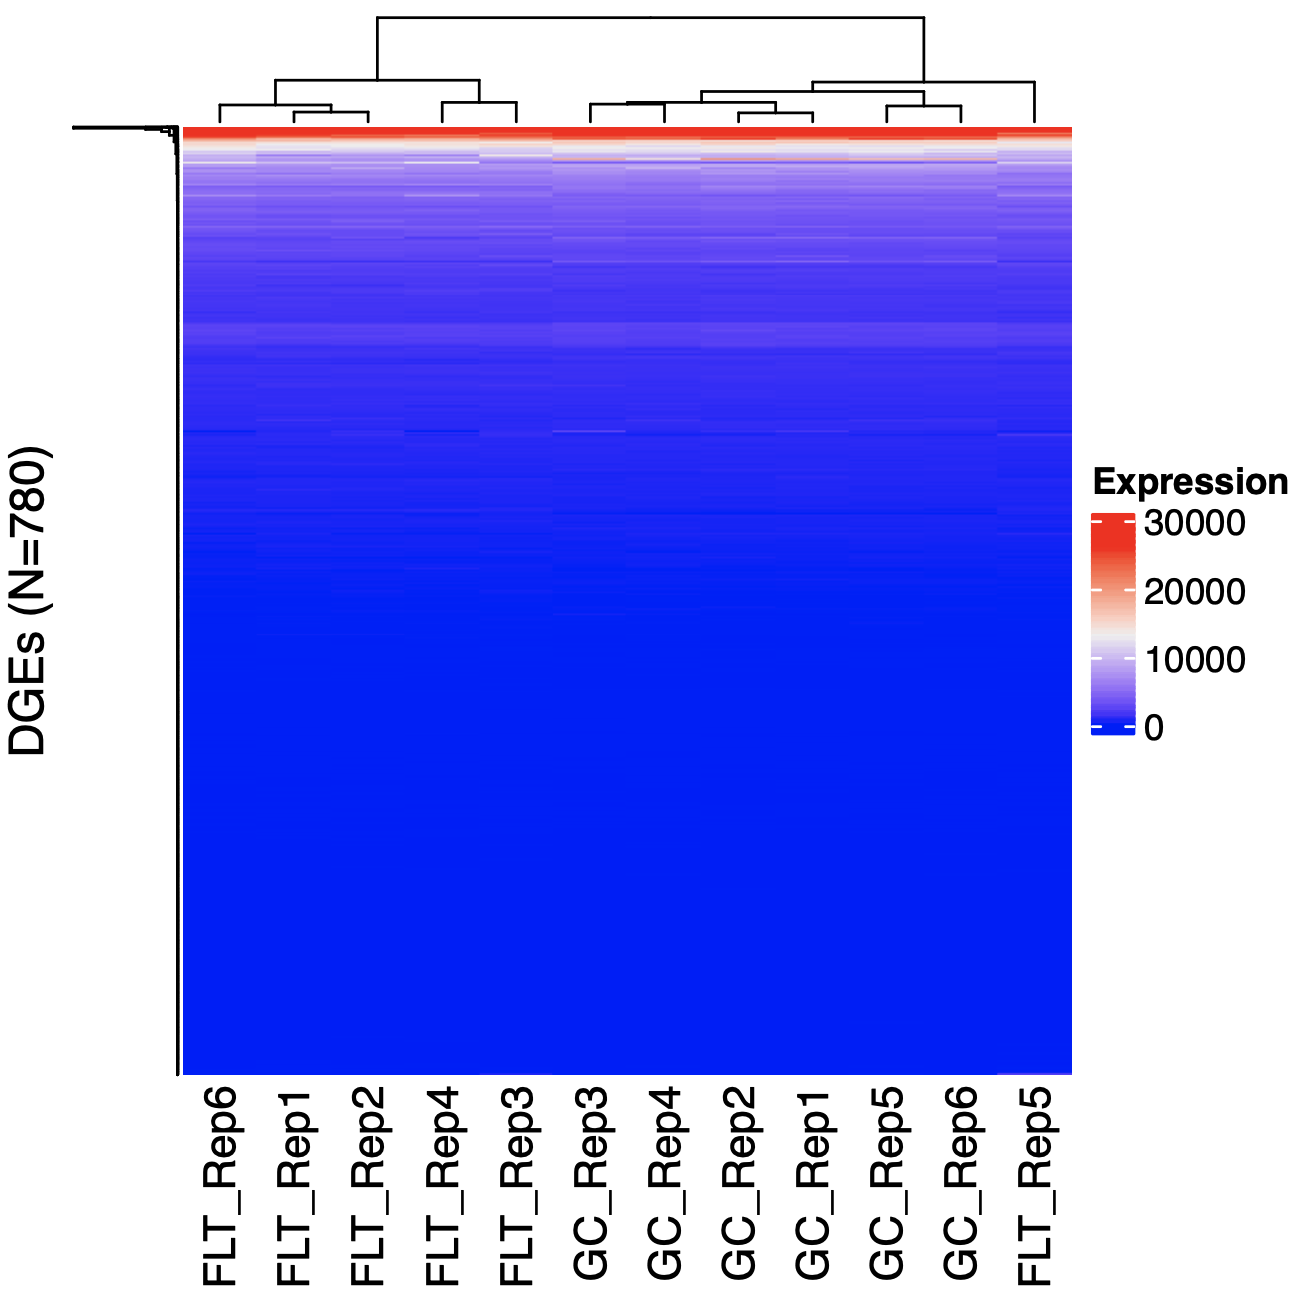

<a class="anchor" id="volcano"></a>
## 5c. Volcano Plot

Next, let's make a volcano plot to identify a few interesting genes. A volcano plot is a scatterplot which shows the relationship of the adjusted p-value to the log2 fold change. Genes with large fold changes that are also statistically significant by adjusted p-value are labeled.

First, we'll use the cutoff settings that we used above: |log2 Fold Change cutoff| > 1, and the adjusted p-value cutoff is < 0.05. 
>Note: You can read more about the `EnhancedVolcano()` function and see some examples by clicking [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html)

In [ ]:
## Volcano plot showing genes differentially expressed in group 1 vs group 2 ##
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = paste("Log2fc_(", g1, ")v(", g2, ")", sep=""),
    y = paste("Adj.p.value_(", g1, ")v(", g2, ")", sep=""),
    title = paste(g1, " vs. ", g2, sep=""),
    legendLabels=c('NS','|Log2FC| > 1','Adj. p-value < 0.05',
      'Adj. p-value < 0.05 & |Log2FC| > 1'),
    pCutoff = 5e-2,
    FCcutoff = 1,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)

## Save your volcano plot ##
ggsave(file.path(DGE_volcano, paste(GLDS, g1, "v", g2, "volcano_DGE.png", sep="_")), width = 11, height = 8.5, dpi = 300)

**Use the volcano plot (and our collective conscious - aka the internet) to answer the following questions:**

1. Which gene has the smallest adjusted p-value that still passes our Log2FC cutoff? 
2. Is that gene more highly expressed in `g1` or `g2` samples? How do you know?
3. Which gene is most highly differentially expressed in `g1`? Does this gene also pass the adjusted p-value cutoff?
4. For the most significant differentially expressed gene, see if you can find its biological function (feel free to use your friend Google to help you out). Are you able to find an annotated function? 

<br>

---

**Challenge:** Use the code blocks below to create another volcano plot (or two) with different adjusted p-value and log2FC cutoffs and see how the plot changes. 
> Hint: Start with the `EnhancedVolcano()` command above then change the values corresponding to the adjusted p-value and log2FC cutoffs. If you're unsure what those are, take a look at the `EnhancedVolcano()` documentation [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html).
>
> Use the information in the `EnhancedVolcano()` documentation [here](https://bioconductor.org/packages/devel/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html#only-label-key-variables) to add labels for specific genes.

<a class="anchor" id="gsea"></a>
## 5d. Gene Set Enrichment Analysis (GSEA)

Finally, let's perform [GSEA](https://www.gsea-msigdb.org/gsea/index.jsp) to determine whether an a priori defined gene set shows statistically significant, concordant differences between two biological states (e.g. phenotypes). 

#### Import Organism-Specific R Libraries:

In [ ]:
## Create a function to identify the GeneLab annotations package used for a give organism ##
fetch_organism_specific_annotation_pkg <- function(organism) {
  all_organism_table <- read.csv("https://raw.githubusercontent.com/nasa/GeneLab_Data_Processing/GL_RefAnnotTable_1.0.0/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110/GL-DPPD-7110_annotations.csv")
  ann.dbi <- all_organism_table %>% dplyr::filter(species == organism) %>% dplyr::pull(annotations)
  # Generate an error message if the organism does not have an associated annotation file yet
  if (length(ann.dbi) == 0) {
    stop(glue::glue("Organism supplied '{organism}' is not supported. See the following url for supported organisms: https://github.com/nasa/GeneLab_Data_Processing/blob/GL_RefAnnotTable_1.0.0/GeneLab_Reference_Annotations/Pipeline_GL-DPPD-7110_Versions/GL-DPPD-7110/GL-DPPD-7110_annotations.csv.  Supported organisms will correspond to a row based on the 'species' column and include a url in the 'genelab_annots_link' column of that row"))
  }
  return(ann.dbi)
}

## Use the function above to specify the GeneLab annotations package for your organism, defined in the runsheet ##
ann.dbi <- fetch_organism_specific_annotation_pkg(unique(df_rs$organism))

## Import and load the GeneLab annotations package for your organism
ann.dbi=as.character(ann.dbi)
library(ann.dbi, character.only=TRUE)

<br>

#### Set DGE Filtering Parameters

Specify the filtering parameters to use to prepare your DGE output table for subsequent GSEA:

- **mean_exp_cutoff**: Cut off value for the average gene expression across all samples. Genes below this value will be removed. 
- **rank_var**: The DESeq2 results statistic you want to use to rank your features (genes), options include:
  - `Log2fc`: Log(2) fold change
  - `Stat`: Wald statistic 
  - `P.value`: p-value 
  - `Adj.p.value`: p-value adjusted for multiple comparisons testing
- **keytype**: The gene IDs used in your DGE analysis above, options include:
  - `ENSEMBL`: For animals
  - `TAIR`: For plants

In [ ]:
mean_exp_cutoff <- 50
rank_var <- "Stat"
keytype <- "ENSEMBL" ## Change ENSEMBL to TAIR for plant studies ##

<br>

#### Filter DGE Results On Contrast of Interest

In [ ]:
## Pull DESeq2 results columns from the DGE table ##
IDs <- DGE_output_table %>% dplyr::select( !!rlang::sym(keytype))
all_mean <- DGE_output_table %>% dplyr::select(All.mean)
log2fc <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("Log2fc_(",g1,")v(",g2,")")))
stat <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("Stat_(",g1,")v(",g2,")")))
pvalue <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("P.value_(",g1,")v(",g2,")")))
padj <- DGE_output_table %>% dplyr::select( !!rlang::sym(paste0("Adj.p.value_(",g1,")v(",g2,")")))

## Combine all DESeq2 results columns from the DGE table ##
DGE_res <- cbind(IDs, all_mean, log2fc, stat, pvalue, padj)

Remove low expressing genes from your `DGE_res` table:

In [ ]:
DGE_res <- DGE_res %>% dplyr::filter(All.mean > mean_exp_cutoff)

Look at the dimensions of your `DGE_res` table after filtering low expressing gened:
> How many genes were removed? (Hint: Subtract this value from the number of features in the `DEG_output_table`)

In [ ]:
dim(DGE_res)

Take a look at your `DGE_res` table:

In [ ]:
head(DGE_res)

Rank the features (genes) in your `DGE_res` dataframe using your `rank_var` indicated above:

In [ ]:
DGE_res_ranked <- DGE_res %>% dplyr::arrange(desc( !!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")"))))

## View your DGE_res table to make sure the data are now ranked in descending order ##
head(DGE_res_ranked)

Extract your `rank_var` column to create your gene list:

In [ ]:
gene_list <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(paste0(rank_var,"_(",g1,")v(",g2,")"))) %>% pull

## Add IDs from the DGE_res_ranked dataframe to the gene_list ##
names(gene_list) <- DGE_res_ranked %>% dplyr::select( !!rlang::sym(keytype)) %>% pull

## View your ranked gene_list ##
head(gene_list)

<br>

#### Set GSEA Parameters

You'll start your gene set enrichment analysis by specifying the following parameters in the code block below:

- **ont**: The sub-ontology to use, options include:
  - `BP`: Biological Processes
  - `MF`: Molecular Function
  - `CC`: Cellular Component
  - `ALL`: Use all three sub-ontologies
- **minGSSize**: Minimum size of a gene set for testing. Gene sets containing a total number of genes below this threshold will be excluded.
- **maxGSSize**: Maximum size of a gene set for testing. Gene sets containing a total number of genes above this threshold will be excluded.
- **pvalueCutoff**: The adjusted p-value cutoff on enrichment tests to report.
- **pAdjustMethod**: Method to use to correct for multiple comparisons testing, options include:
> You can learn more about each of the methods listed below in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/).
  - `holm`: Holm adjustment
  - `hochberg`: Hochberg adjustment
  - `hommel`: Hommel adjustment
  - `bonferroni`: Bonferroni adjustment
  - `BH`: Benjamini-Hochberg adjustment
  - `BY`: Benjamini and Yekutieli adjustment
  - `fdr`: false discovery rate
  - `none`: Do not correct for multiple comparisons testing

In [ ]:
ont <- "BP"
minGSSize <- 10
maxGSSize <- 500
pvalueCutoff <- 0.05
pAdjustMethod <- "BH"

<br>

#### Run GSEA Using Gene Ontology (GO)

In this section we will use geneset enrichment analyses provided in the [clusterProfiler](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) package on [Bioconductor](http://www.bioconductor.org/). There are a variety of different tools in `clusterProfiler` that allow you to run GSEA using several different types of gene sets. Here we use the genesets associated with the [gene ontologies (GO)](http://geneontology.org/) of our species of interest. You are welcome (and encouraged) to check out the [clusterProfiler](https://bioconductor.org/packages/release/bioc/manuals/clusterProfiler/man/clusterProfiler.pdf) documentation and set up additional code blocks to run GSEA using different types of gene sets.

In [ ]:
gse <- gseGO(geneList = gene_list,
             ont = ont,
             keyType = keytype,
             minGSSize = minGSSize,
             maxGSSize = maxGSSize,
             pvalueCutoff = pvalueCutoff,
             pAdjustMethod = pAdjustMethod,
             OrgDb = ann.dbi,
             by = "fgsea")

View your GSEA output table:

>The output results table contains the following information:
>
>- **ID**: Gene set IDs, here we are using Gene Ontologies (GO).
>- **Description**: Indicates the name of the sub-ontology set, the sub-ontology set type defined as the `ont` variable specified above.
>- **setSize**: The number of genes in the gene set, after filtering out genes that are not present in the input expression dataset.
>- **enrichmentScore**: Unnormalized enrichment score (ES), determined based on how much a gene set is overrepresented at the top or bottom of a ranked list of genes. A positive ES indicates gene set enrichment at the top of the ranked list whereas a negative ES indicates gene set enrichment at the bottom of a ranked list.
>- **NES**: Normalized enrichment score, the ES after correcting for differences in ES between gene sets due to differences in the size of the gene sets evaluated.
>- **pvalue**: An enrichment p-value representing the statistical significance of the ES, which does not take into account differences in gene set size and has not been adjusted for multiple hypothesis testing. (This is not a useful metric to determine significance.)
>- **p.adjust**: A p-value adjusted for multiple testing using the correction method specified with the `pAdjustMethod` variable above.
>- **qvalue**: A measure of the false discovery rate (FDR), which is the estimated probability that a gene set with a given NES representsa false positive finding. The closer the qvalue is to zero, the greater the perturbation of the gene set. Although q-values are always positive (between 0 and 1), the gsea augments the value with either a positive or negative sign to indicate up-regulation or down-regulation, respectively, of a gene set.
>- **rank**: The position in the ranked list at which the maximum enrichment score occurred. Genesets that achieve the maximum enrighment score towards the top or bottom of the ranked listed provided are the most interesting.
>- **leading_edge**: 3 statistics that define the leading edge subset of a gene set, the subset of members of the gene set that contribute the most to the ES.
>   - **tags**: The % of gene hist before (for positive ES) or after (for negative ES) the peak in the running enrichment score, which indicates the % of genes in the gene set contributing to the ES.
>   - **list**: The % of genes in the ranked gene list before (for positive ES) or after (for negative ES) the peak in the running enrichment score, which indicates where in the list the ES is attained.
>   - **signal**: The enrichment signal strength that contributes to the 2 statistics described above. A maximal signal strength (100%) occurs if all genes in the gene set are within the very top (or bottom) of the ranked list of genes, and a minimal signal strength (0%) occurs if the genes in the gene set are spread throughout the ranked gene list. 
>- **core_enrichment**: Genes that contribute to the leading edge subset of the gene set, these genes contribute most to the enrichment result.

To learn more about how to interpret GSEA results check out the "Interpreting GSEA Results" section of the [GSEA User Guide](http://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html).

In [ ]:
gse_table <- as.data.frame(gse)

## Save the GSEA output table to a file ##
write.csv(gse_table,file.path(DGE_gsea, paste(GLDS, g1, "v", g2, "GSEA", rank_var, "ranked_output.csv", sep="_")))

head(gse_table)

<br>

#### Create Dotplot of GSEA GO Results

Use the GSEA GO results above to create a dotplot indicating the gene ontologies that are activated and suppressed in your specified contrast.
> Adjust the `showCategory` parameter below to show more or less gene ontilogies

In [ ]:
require(DOSE)
dotplot(gse, showCategory=10, split=".sign") + facet_grid(.~.sign)

## Save your dotplot ##
ggsave(file.path(DGE_gsea, paste(GLDS, g1, "v", g2, "GSEA", rank_var, "ranked_dotplot.png", sep="_")), width = 11, height = 8.5, dpi = 300)

<br>

#### Create an Enrichment Map of GSEA GO Results

Use the GSEA GO results above to organize the enriched gene ontologies into a network with edges connecting over-lapping gene sets. Note that overlapping gene sets (ontologies) cluster together. 
> Adjust the `showCategory` parameter below to show more or less gene ontologies

In [ ]:
gse_pairwise_termsim <- pairwise_termsim(gse)
emapplot(gse_pairwise_termsim, showCategory = 10)

## Save your network enrichment map ##
ggsave(file.path(DGE_gsea, paste(GLDS, g1, "v", g2, "GSEA", rank_var, "ranked_network_map.png", sep="_")), width = 11, height = 8.5, dpi = 300)